# AWD-LSTM (ULMFit)

In this notebook we train an AWD-LSTM model for the proxy task with language model pretraining on IMSLP and language model fine-tuning on the target data.  This notebook has been adapted from the fast.ai [ULMFit tutorial](https://github.com/fastai/course-nlp/blob/master/nn-vietnamese.ipynb).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.text import *
import glob
import eval_models

/home/kdey/micromamba/envs/pse/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
bs=48

In [3]:
torch.cuda.set_device(0)

In [4]:
data_path = Config.data_path()

In [5]:
name = 'bscore_lm'
path = data_path/name
path.mkdir(exist_ok=True, parents=True)

### IMSLP Language Model

In [6]:
data = load_data(path, 'lm_imslp_databunch', bs=bs)

In [7]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.5, pretrained=False)

In [8]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


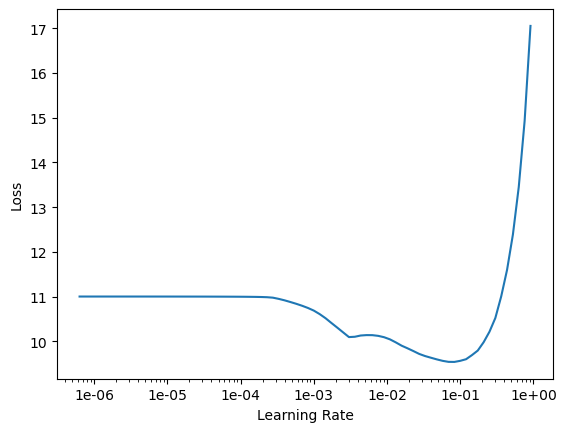

In [9]:
learn.recorder.plot()

In [10]:
lr = 3e-3

In [11]:
learn.unfreeze()
learn.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.704123,6.825674,0.033625,16:11


In [12]:
learn.fit_one_cycle(10, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.751542,6.866901,0.024103,16:17
1,6.859155,6.910577,0.023688,16:19
2,6.890357,6.931955,0.033625,16:12
3,6.921969,6.921094,0.023802,16:16
4,6.647561,6.923466,0.033625,16:19
5,6.812690,6.901229,0.023802,16:19
6,6.157326,6.155074,0.072155,16:25
7,6.116271,6.028799,0.075438,16:28
8,5.978178,5.961911,0.076707,16:25
9,5.917929,5.947100,0.077284,16:27


In [13]:
learn.fit_one_cycle(5, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.944312,6.003721,0.077286,16:29
1,6.108537,5.999419,0.074793,16:22
2,6.008843,5.913651,0.078462,16:36
3,5.875874,5.824881,0.076986,16:26
4,5.863880,5.788571,0.080221,16:26


In [14]:
learn.fit_one_cycle(5, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.760996,5.906658,0.077099,16:29
1,5.915617,5.917357,0.077528,16:27
2,5.899685,5.865664,0.076936,16:30
3,5.883934,5.762815,0.082811,16:27
4,5.874158,5.725037,0.083468,16:22


In [15]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True, parents=True)

In [16]:
model_basename = 'awdlstm_train-imslp_lm'
learn.save(mdl_path/f'{model_basename}_wt', with_opt=False)
learn.data.vocab.save(mdl_path/f'{model_basename}_vocab.pkl')

### Finetune Language Model

In [17]:
data_target_lm = load_data(path, 'lm_target_databunch', bs=bs)

In [18]:
lm_fns = [mdl_path/f'{model_basename}_wt', mdl_path/f'{model_basename}_vocab']
learn_lm = language_model_learner(data_target_lm, AWD_LSTM, pretrained_fnames=lm_fns, drop_mult=1.0)

In [19]:
learn_lm.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


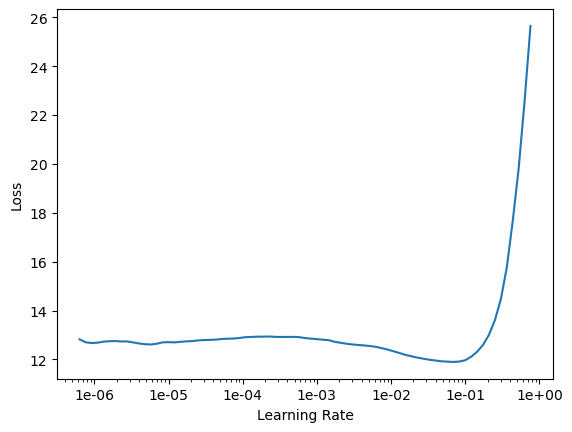

In [20]:
learn_lm.recorder.plot()

In [21]:
lr = 1e-3

In [22]:
learn_lm.fit_one_cycle(2, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,7.470451,6.479064,0.064521,00:15
1,6.880929,6.124602,0.062696,00:15


In [23]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(8, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.935287,5.496335,0.090335,00:18
1,5.577995,5.170533,0.100540,00:18
2,5.336459,5.028930,0.106446,00:18
3,5.255887,4.936432,0.115296,00:18
4,5.191999,4.886343,0.123449,00:18
5,5.044835,4.842362,0.133686,00:18
6,5.018889,4.822254,0.139756,00:18
7,5.012424,4.817284,0.141291,00:18


In [24]:
ftmodel_basename = 'awdlstm_train-imslp_finetune-target_lm'
learn_lm.save(ftmodel_basename)
learn_lm.save_encoder(f'{ftmodel_basename}enc')

### Train Classifier

In [25]:
train_df = pd.read_csv(path/'train64.csv')
valid_df = pd.read_csv(path/'valid64.csv')
test_df = pd.read_csv(path/'test64.csv')

In [26]:
basicTokenizer = Tokenizer(pre_rules=[], post_rules=[])
data_clas = TextDataBunch.from_df(path, train_df, valid_df, tokenizer=basicTokenizer,
                                  vocab = data_target_lm.vocab, bs=bs, num_workers=1)

In [27]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, pretrained=False, drop_mult=0.5, 
                                  metrics=[accuracy, FBeta(average='macro', beta=1)])
learn_c.load_encoder(f'{ftmodel_basename}enc')
learn_c.freeze()

In [28]:
learn_c.lr_find()

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


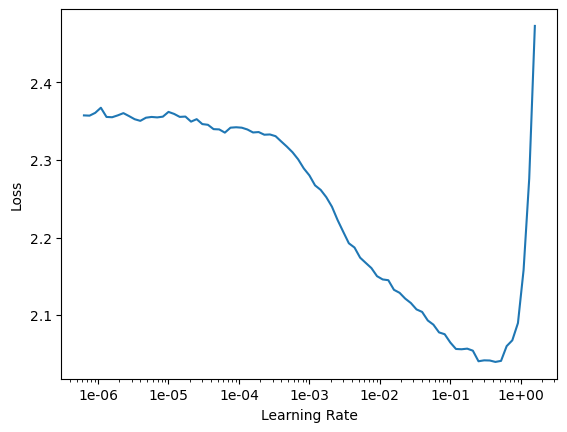

In [29]:
learn_c.recorder.plot()

In [30]:
lr = 3e-4

In [31]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.580867,1.605535,0.413611,0.398409,00:12
1,1.466913,1.539026,0.439167,0.426177,00:12


In [32]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.412611,1.531011,0.444630,0.431374,00:12
1,1.388112,1.502289,0.453519,0.442062,00:12


In [33]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.290835,1.440325,0.474722,0.466060,00:15
1,1.210984,1.414722,0.486481,0.478640,00:15


In [34]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.187844,1.416083,0.489259,0.482407,00:19
1,1.121800,1.403149,0.495000,0.486616,00:19


In [35]:
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.054598,1.389958,0.498981,0.492284,00:25


In [36]:
learn_c.save('awdlstm_train-imslp_finetune-target_clas')

In [37]:
learn_c.load('awdlstm_train-imslp_finetune-target_clas')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (32400 items)
x: TextList
xxbos 274878955520 34360262656 17179869440 1099511627776 549755813888 274877906944 137438953472 68719476736 8590458880 34360852480 137438953472 274913558528 8796093022208 4398046511104 2199057891328 2199023255552 1099680448512 1099511627776 549756076032 137438953472 156766339072 68719476736 137438953472 141733920768 274877906944 137438953472 1099511758848 137438953472 1108101824512 68719476736 xxunk 68719476736 2097152 180388888576 2097152 317829677056 4194304 2097152 592705748992 1048576 8590458880 xxunk 524288 xxunk 592705748992 592705519616 1048576 317828104192 575525650432 285615587328 138512695296 2048 9663677440 2048 36775657472 19327352832 xxunk 294205390848 262144 142807662592 18210679160832 1099511627776 1133871366144 2199023255552,xxbos 34359738368 68736778240 549755813888 2199023255552 274877906944 549773115392 2199023255552 8796093022208 1099511627776 2199023288320 8796093022208 70368744177664 43

### Evaluate Classifier

Evaluate on the proxy task -- classifying fixed-length chunks of bootleg score features.

In [38]:
data_clas_test = TextDataBunch.from_df(path, train_df, test_df, tokenizer=basicTokenizer,
                                       vocab = data_target_lm.vocab, bs=bs, num_workers=1)

In [39]:
learn_c.validate(data_clas_test.valid_dl)

[1.4316337, tensor(0.5008), tensor(0.4866)]

Evaluate on the original task -- classifying pages of sheet music.  We can evaluate our models in two ways:
- applying the model to a variable length sequence
- applying the model to multiple fixed-length windows and averaging the predictions

First we evaluate the model on variable length inputs.  Report results with and without applying priors.


In [40]:
train_fullpage_df = pd.read_csv(path/'train.fullpage.csv')
valid_fullpage_df = pd.read_csv(path/'valid.fullpage.csv')
test_fullpage_df = pd.read_csv(path/'test.fullpage.csv')

In [41]:
(acc, acc_with_prior), (f1, f1_with_prior) = eval_models.calcAccuracy_fullpage(learn_c, path, train_fullpage_df, valid_fullpage_df, test_fullpage_df)
(acc, acc_with_prior), (f1, f1_with_prior)

/home/kdey/micromamba/envs/pse/lib/python3.7/site-packages/fastai/core.py:299: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


((0.49229639768600464, 0.5744680762290955),
 (0.4713035378052436, 0.5147929368592893))

Now we evaluate the model by considering multiple fixed-length windows and averaging the predictions.

In [42]:
test_ensemble_df = pd.read_csv(path/'test.ensemble64.csv')

In [43]:
(acc, acc_with_prior), (f1, f1_with_prior) = eval_models.calcAccuracy_fullpage(learn_c, path, train_fullpage_df, valid_fullpage_df, test_ensemble_df, ensembled=True)
(acc, acc_with_prior), (f1, f1_with_prior)

/home/kdey/micromamba/envs/pse/lib/python3.7/site-packages/fastai/core.py:299: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


((0.5649303197860718, 0.6118855476379395),
 (0.5155983341115408, 0.505952243718363))

### Error Analysis

In [44]:
interp = ClassificationInterpretation.from_learner(learn_c)

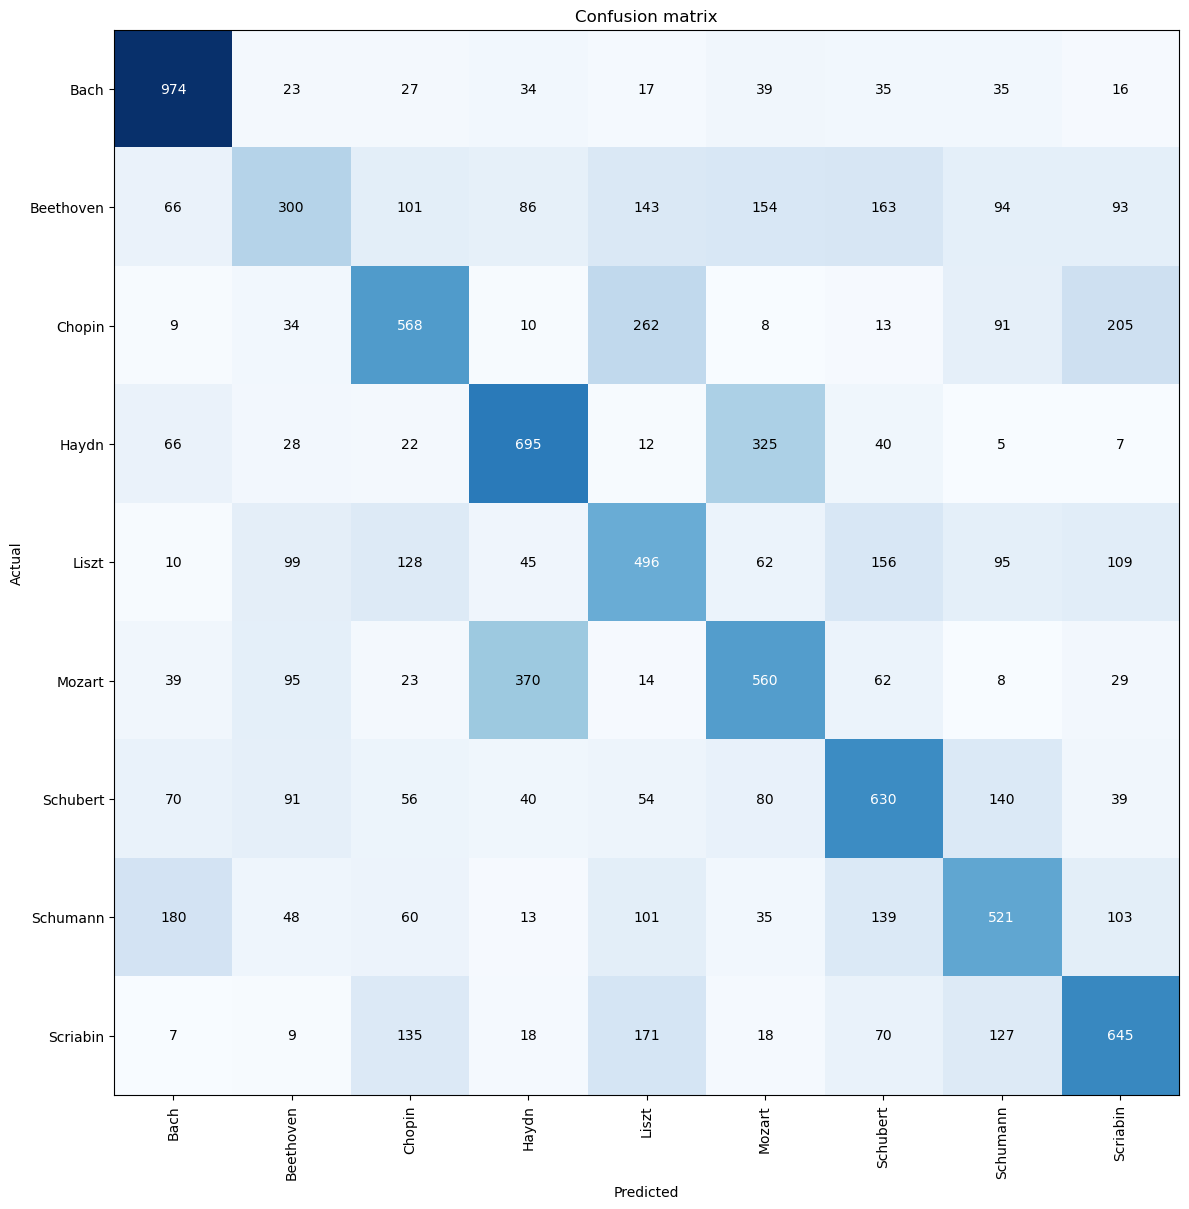

In [45]:
interp.plot_confusion_matrix(figsize=(12,12))